In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [ ]:
data_dir_str = "/content/drive/MyDrive/AlternariaSE"
data_dir = pathlib.Path(data_dir_str)

In [ ]:
image_count = len(list(data_dir.glob('*/*.JPG')))
image_count

150

In [ ]:
sick = list(data_dir.glob('ENFERMAS/*.JPG'))
healthy = list(data_dir.glob('SANAS/*.JPG'))
print(len(sick))
print(len(healthy))

140
10


In [ ]:
batch_size = 10
img_height = 200
img_width = 200

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 159 files belonging to 2 classes.
Using 128 files for training.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['ENFERMAS', 'SANAS']


In [ ]:
print(type(train_ds)) #lista de tuplas de forma (batch images, labels)
tensor1,labels1=next(iter(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [ ]:
print(tensor1)
print(labels1)

tf.Tensor(
[[[[ 12.    12.    16.5 ]
   [ 12.    12.    14.  ]
   [ 13.    13.    14.  ]
   ...
   [ 14.25  14.75  16.75]
   [ 12.    11.    11.5 ]
   [ 14.    13.    11.  ]]

  [[ 16.    16.    20.5 ]
   [ 16.75  15.75  20.75]
   [ 15.75  20.25  23.25]
   ...
   [ 13.    13.    15.  ]
   [ 11.5   12.5   14.5 ]
   [ 18.75  19.75  21.75]]

  [[ 16.25  17.25  19.25]
   [ 12.5   12.5   12.5 ]
   [ 16.25  16.25  17.25]
   ...
   [ 10.5   11.    13.  ]
   [ 18.25  16.25  17.25]
   [ 22.75  23.75  26.75]]

  ...

  [[ 13.5   14.    15.  ]
   [ 17.    21.5   25.  ]
   [ 25.75  29.75  31.75]
   ...
   [  3.     4.     7.  ]
   [ 14.75  16.75  15.75]
   [ 19.75  19.25  22.75]]

  [[  8.     8.     7.  ]
   [ 20.75  20.75  20.75]
   [ 15.    16.    18.  ]
   ...
   [ 11.75  11.75  13.75]
   [ 10.5   14.5   17.5 ]
   [  9.75  10.75  12.75]]

  [[  7.75   6.75   8.25]
   [  7.75   7.75   9.75]
   [ 19.75  20.75  20.25]
   ...
   [ 16.5   19.    21.5 ]
   [ 14.25  18.25  19.25]
   [ 40.5   41.    4

ENFERMAS


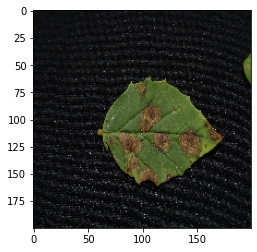

In [ ]:
plt.imshow(tensor1[0].numpy().astype("uint8"))
print(class_names[labels1[0]])

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 159 files belonging to 2 classes.
Using 31 files for validation.


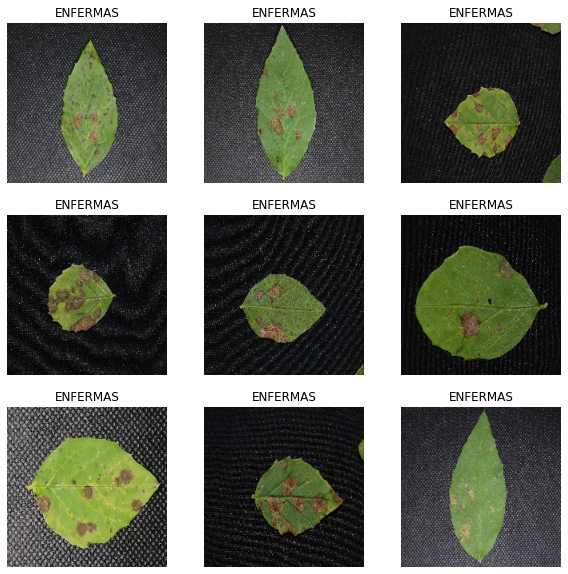

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
testb, testl=next(iter(train_ds))
print(testb.shape)
print(testl.shape)

(10, 200, 200, 3)
(10,)


0.0     0.8950981


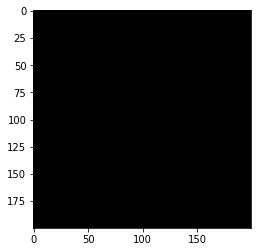

In [ ]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image),'   ', np.max(first_image))
plt.imshow(first_image.numpy().astype("uint8"))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 2

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 64)       

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
13/13 [==============================] - 26s 696ms/step - loss: 0.3038 - accuracy: 0.9297 - val_loss: 2.0036 - val_accuracy: 0.8710
Epoch 2/10
13/13 [==============================] - 4s 312ms/step - loss: 0.6899 - accuracy: 0.9531 - val_loss: 0.4376 - val_accuracy: 0.8710
Epoch 3/10
13/13 [==============================] - 4s 311ms/step - loss: 0.3273 - accuracy: 0.9531 - val_loss: 0.3991 - val_accuracy: 0.8710
Epoch 4/10
13/13 [==============================] - 4s 309ms/step - loss: 0.1932 - accuracy: 0.9531 - val_loss: 0.6766 - val_accuracy: 0.8710
Epoch 5/10
13/13 [==============================] - 4s 314ms/step - loss: 0.2809 - accuracy: 0.9531 - val_loss: 0.3858 - val_accuracy: 0.8710
Epoch 6/10
13/13 [==============================] - 4s 311ms/step - loss: 0.1893 - accuracy: 0.9531 - val_loss: 0.4631 - val_accuracy: 0.8710
Epoch 7/10
13/13 [==============================] - 4s 313ms/step - loss: 0.1851 - accuracy: 0.9531 - val_loss: 0.3929 - val_accuracy: 0.8710
Epoch

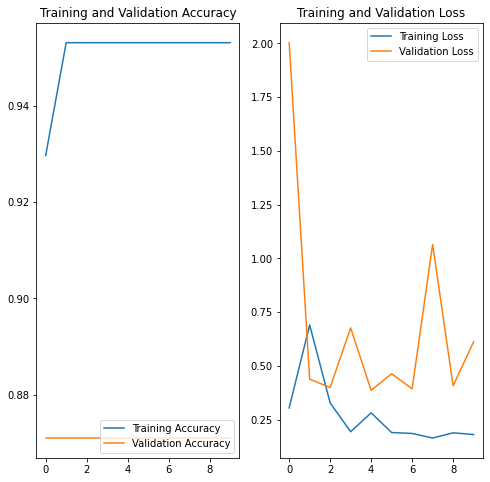

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

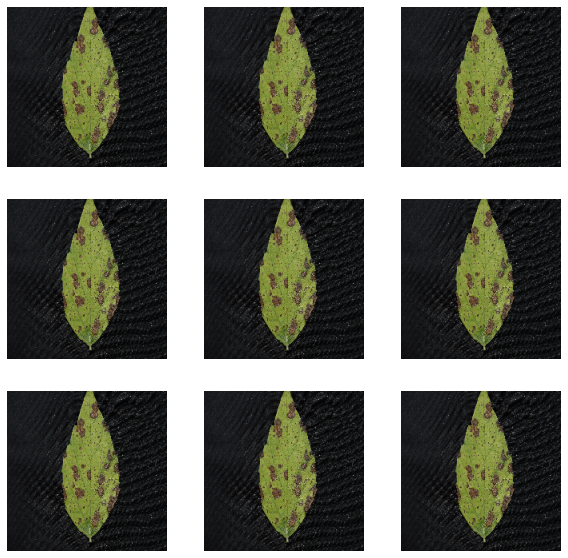

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                 

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
13/13 [==============================] - 6s 363ms/step - loss: 0.2329 - accuracy: 0.9531 - val_loss: 0.3993 - val_accuracy: 0.8710
Epoch 2/10
13/13 [==============================] - 5s 356ms/step - loss: 0.1738 - accuracy: 0.9531 - val_loss: 0.5729 - val_accuracy: 0.8710
Epoch 3/10
13/13 [==============================] - 4s 346ms/step - loss: 0.1530 - accuracy: 0.9531 - val_loss: 0.6871 - val_accuracy: 0.8710
Epoch 4/10
13/13 [==============================] - 5s 348ms/step - loss: 0.1638 - accuracy: 0.9531 - val_loss: 0.5231 - val_accuracy: 0.8710
Epoch 5/10
13/13 [==============================] - 5s 351ms/step - loss: 0.1537 - accuracy: 0.9531 - val_loss: 0.5878 - val_accuracy: 0.8710
Epoch 6/10
13/13 [==============================] - 4s 345ms/step - loss: 0.1500 - accuracy: 0.9531 - val_loss: 0.6447 - val_accuracy: 0.8710
Epoch 7/10
13/13 [==============================] - 4s 352ms/step - loss: 0.1663 - accuracy: 0.9531 - val_loss: 0.7153 - val_accuracy: 0.8710
Epoch 

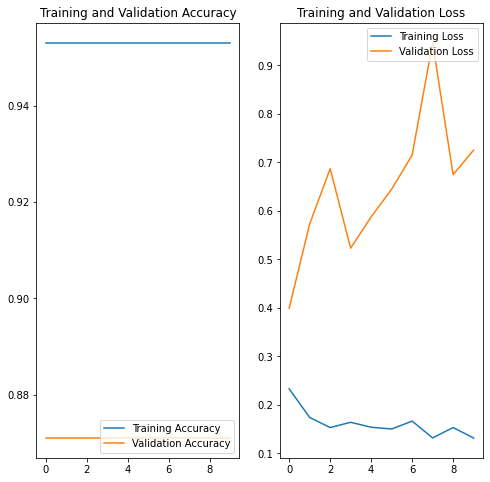

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
img1 = tf.keras.utils.load_img(
    '/content/drive/MyDrive/AlternariaSE/ENFERMAS/DSC_0011.JPG', target_size=(img_height, img_width)
)
img2= tf.keras.utils.load_img(
    '/content/drive/MyDrive/AlternariaSE/SANAS/DSC_0859.JPG', target_size=(img_height, img_width)
)

In [ ]:
img_array1 = tf.keras.utils.img_to_array(img1)
img_array1 = tf.expand_dims(img_array1, 0) # Create a batch

predictions = model.predict(img_array1)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to ENFERMAS with a 99.95 percent confidence.


In [ ]:
img_array2 = tf.keras.utils.img_to_array(img2)
img_array2 = tf.expand_dims(img_array2, 0) # Create a batch

predictions = model.predict(img_array2)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to ENFERMAS with a 59.48 percent confidence.


In [ ]:
img3= tf.keras.utils.load_img(
    '/content/drive/MyDrive/AlternariaSE/SANAS/DSC_0959.JPG', target_size=(img_height, img_width)
)
img_array3 = tf.keras.utils.img_to_array(img3)
img_array3 = tf.expand_dims(img_array3, 0) # Create a batch

predictions = model.predict(img_array3)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to ENFERMAS with a 88.09 percent confidence.
